<a href="https://www.kaggle.com/code/mohammadalnajdawi/alexnet-model-mayo-clinic?scriptVersionId=103556501" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Library

In [58]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import IPython.display

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from PIL import Image
from glob import glob
import scipy as sp
import numpy as np
import pandas as pd
#import Pyvips

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, regionprops_table
from sklearn.preprocessing import StandardScaler
from scipy import ndimage as ndi
from matplotlib.patches import Rectangle

import torchvision

from tqdm.auto import tqdm
from tqdm import trange
from time import sleep
from functools import partial
import tifffile as tiff

import cv2 as cv
from openslide import OpenSlide
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import torchvision.transforms as transforms
import torch.optim as optim
import gc

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

from torch.cuda.amp import autocast, GradScaler
Image.MAX_IMAGE_PIXELS = None
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading data

In [3]:
train_data = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
transformed_train = pd.read_csv('../input/mayo-clinic-output/new_train.csv')
#print(train_data.head())
print(train_data[train_data["image_id"]=="1a2e9e_0"])
train_data['enc_label'] = np.where(train_data['label']== 'CE', 1, 0)
train, vaild = train_test_split(train_data, test_size=0.204)
test = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
sample_sub = pd.read_csv('../input/mayo-clinic-strip-ai/sample_submission.csv')


    image_id  center_id patient_id  image_num label
77  1a2e9e_0         11     1a2e9e          0    CE


# EDA

In [4]:
print(train.head())
train[train["label"]=="LAA"]

     image_id  center_id patient_id  image_num label  enc_label
497  a975ab_1          7     a975ab          1    CE          1
189  3d80c7_0         11     3d80c7          0   LAA          0
626  d923a7_0         11     d923a7          0    CE          1
673  e7d583_0          7     e7d583          0    CE          1
418  8c24eb_0         11     8c24eb          0    CE          1


,image_id,center_id,patient_id,image_num,label,enc_label
189,3d80c7_0,11,3d80c7,0,LAA,0
701,f3e9f6_0,4,f3e9f6,0,LAA,0
679,eb21f0_0,11,eb21f0,0,LAA,0
587,cb4f8e_1,11,cb4f8e,1,LAA,0
513,b01110_0,4,b01110,0,LAA,0
...,...,...,...,...,...,...
350,73c9a4_0,4,73c9a4,0,LAA,0
434,91b9d3_1,3,91b9d3,1,LAA,0
660,e3e850_0,11,e3e850,0,LAA,0
507,adc6e3_0,11,adc6e3,0,LAA,0


In [5]:
patients_train = train['patient_id'].nunique()
patients_test = test['patient_id'].nunique()
print(f"Number of unique patient {patients_train}")


Number of unique patient 521


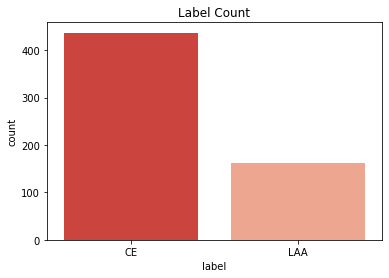

In [6]:
sns.countplot(train.label, palette="Reds_r")
plt.title("Label Count");

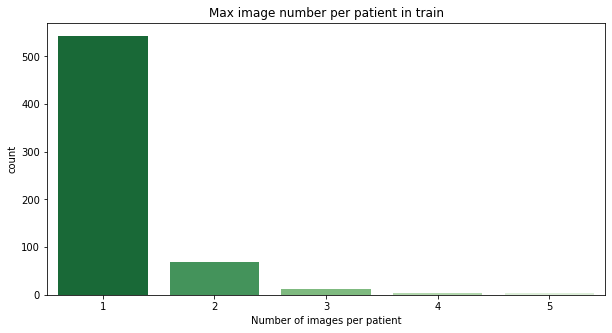

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(train_data.groupby("patient_id").image_num.size(), palette="Greens_r")
plt.xlabel("Number of images per patient")
plt.title("Max image number per patient in train");


# Image Transformation 

In [8]:
def rezie_image(image):
    resized_image = cv.resize(image,(int(image.shape[1]/33),int(image.shape[0]/33)),interpolation= cv.INTER_LINEAR)
    return resized_image

In [9]:
def grey_resize(image):
    gray_resized_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)    
    return gray_resized_image

In [10]:
def labeled_segment(grey_resized_image):
    elevation_map = sobel(grey_resized_image)
    markers = np.zeros_like(grey_resized_image)
    markers[grey_resized_image >= grey_resized_image.mean()] = 1
    markers[grey_resized_image < grey_resized_image.mean()] = 2
    segmented_img = segmentation.watershed(elevation_map, markers)
    filled_segments = ndi.binary_fill_holes(segmented_img - 1)
    labeled_segments, _ = ndi.label(filled_segments)
    return labeled_segments


In [11]:
def plot_labeled_segments(labeled_segments, resized_gray_img):
    image_label_overlay = label2rgb(labeled_segments, image=resized_gray_img, bg_label=0)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image_label_overlay, cmap=plt.cm.gray)
    ax.set_title('segmentation')
    ax.axis('off')


In [12]:
def get_object_coordinates(labeled_segments):
    properties =['area','bbox','convex_area','bbox_area', 'major_axis_length', 'minor_axis_length', 'eccentricity']
    df = pd.DataFrame(regionprops_table(labeled_segments, properties=properties))
    standard_scaler = StandardScaler()
    scaled_area = standard_scaler.fit_transform(df.area.values.reshape(-1,1))
    df['scaled_area'] = scaled_area
    df.sort_values(by="scaled_area", ascending=False, inplace=True)
    objects = df[df['scaled_area']>=.75]
    object_coordinates = [(row['bbox-0'],row['bbox-1'],row['bbox-2'],row['bbox-3'] )for index, row in objects.iterrows()]
    return object_coordinates


In [13]:
def plot_object_coordinates(object_coordinates, resized_image):
    fig, ax = plt.subplots(1,1, figsize=(18, 16), dpi = 80)
    for blob in object_coordinates:
        width = blob[3] - blob[1]
        height = blob[2] - blob[0]
        patch = Rectangle((blob[1],blob[0]), width, height, edgecolor='r', facecolor='none')


In [14]:
def save_objects(object_coordinates, image, image_name, label, count):
    plt.figure(figsize=(10,18))
    for i in range(len(object_coordinates)):
        coordinates = object_coordinates[i]
        object_image = image[int(coordinates[0]):int(coordinates[2]), int(coordinates[1]):int(coordinates[3])]
        #plt.imshow(object_image)
        image_new_name = image_name + "_" + str(i)
        new_train["image_name"].append(image_new_name)
        new_train["label"].append(label)
        new_train["image_count"].append(count)
        cv.imwrite(os.path.join("./", f"{image_new_name}.jpg"), object_image)
        



In [15]:
"""train_path = "../input/mayo-clinic-strip-ai/train"
Image_names = train['image_id'].values
new_train={"image_count":[],"image_name":[],"label":[]}
count=1
scale = 4
for image_name in Image_names:
    Image_label = train.loc[train['image_id'] == image_name, 'enc_label'].iloc[0]
    image = tiff.imread(os.path.join(train_path, f"{image_name}.tif"))
    resized_image=rezie_image(image)
    del image
    gc.collect()
    grey_resized_image = grey_resize(resized_image)
    labeled_segments = labeled_segment(grey_resized_image)
    object_coordinates = get_object_coordinates(labeled_segments)
    save_objects(object_coordinates, resized_image, image_name, Image_label,count)
    count+=1
    #if count == 80:
    #    break
new_train=pd.DataFrame.from_dict(new_train)"""

'train_path = "../input/mayo-clinic-strip-ai/train"\nImage_names = train[\'image_id\'].values\nnew_train={"image_count":[],"image_name":[],"label":[]}\ncount=1\nscale = 4\nfor image_name in Image_names:\n    Image_label = train.loc[train[\'image_id\'] == image_name, \'enc_label\'].iloc[0]\n    image = tiff.imread(os.path.join(train_path, f"{image_name}.tif"))\n    resized_image=rezie_image(image)\n    del image\n    gc.collect()\n    grey_resized_image = grey_resize(resized_image)\n    labeled_segments = labeled_segment(grey_resized_image)\n    object_coordinates = get_object_coordinates(labeled_segments)\n    save_objects(object_coordinates, resized_image, image_name, Image_label,count)\n    count+=1\n    #if count == 80:\n    #    break\nnew_train=pd.DataFrame.from_dict(new_train)'

# Data Loader

In [16]:
class TrainDataset(Dataset):
    def __init__(self, path, df, transform=None):
        self.df = df
        self.path = path
        self.Image_names = df['image_name'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.Image_names[idx]
        img= Image.open(os.path.join(self.path, f"{file_name}.jpg"))
        if self.transform:
            image=self.transform(img)

        label = self.labels[idx]

        return image, torch.tensor(label)

# Transforms

In [17]:
batch_size=64
data_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
train_dataset = TrainDataset("../input/mayo-clinic-output/", transformed_train, transform = data_transform)
#vaild_dataset = TrainDataset("../input/mayo-clinic-strip-ai/train", vaild, transform = data_transform)
#test_dataset = TrainDataset("../input/mayo-clinic-strip-ai/train", test, transform = data_transform)

dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=0)
#dataset_loader_vaild = torch.utils.data.DataLoader(vaild_dataset,
#                                             batch_size=batch_size, shuffle=True,
#                                             num_workers=0)


# Binary accuracy metric

In [18]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc


# AlexNet Model

In [19]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=1)


    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training 

In [20]:
"""model = AlexNet()
#model = VGG16()
model = model.to(device=device)
print(device)
## Loss and optimizer
learning_rate = 1e-3 #I picked this because it seems to be the most used by experts
load_model = True
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning
for epoch in range(10): #I decided to train the model for 5 epochs
    with tqdm(dataset_loader, unit="batch") as tepoch:
        e=epoch+1
        loss_ep = 0
        epoch_acc = 0

        for (data, targets) in (tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            
            data = data.to(device=device).requires_grad_(True)
            targets = targets.type(torch.FloatTensor).to(device=device).requires_grad_(True)
            optimizer.zero_grad()
            y_pred = model(data)
            sco = torch.clamp(y_pred,0,1)
            loss = criterion(sco.squeeze(),targets)
            acc = binary_acc(sco.squeeze(),targets)
            loss.backward()
            optimizer.step()
            loss_ep += loss.item()
            epoch_acc += acc.item()
            tepoch.set_postfix(loss=loss.item(), accuracy=100. * acc.item())
            sleep(0.1)
    print(f'Epoch {e+0:03}: | Loss: {loss_ep/len(dataset_loader):.5f} | Acc: {epoch_acc/len(dataset_loader):.3f}')

        
   """

'model = AlexNet()\n#model = VGG16()\nmodel = model.to(device=device)\nprint(device)\n## Loss and optimizer\nlearning_rate = 1e-3 #I picked this because it seems to be the most used by experts\nload_model = True\ncriterion = nn.BCELoss()\noptimizer = optim.Adam(model.parameters(), lr= learning_rate) #Adam seems to be the most popular for deep learning\nfor epoch in range(10): #I decided to train the model for 5 epochs\n    with tqdm(dataset_loader, unit="batch") as tepoch:\n        e=epoch+1\n        loss_ep = 0\n        epoch_acc = 0\n\n        for (data, targets) in (tepoch):\n            tepoch.set_description(f"Epoch {epoch}")\n            \n            data = data.to(device=device).requires_grad_(True)\n            targets = targets.type(torch.FloatTensor).to(device=device).requires_grad_(True)\n            optimizer.zero_grad()\n            y_pred = model(data)\n            sco = torch.clamp(y_pred,0,1)\n            loss = criterion(sco.squeeze(),targets)\n            acc = binar

In [21]:
"""with torch.no_grad():
        num_correct = 0
        num_samples = 0
        
        for batch_idx, (data,targets) in enumerate(dataset_loader_vaild):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )"""

'with torch.no_grad():\n        num_correct = 0\n        num_samples = 0\n        \n        for batch_idx, (data,targets) in enumerate(dataset_loader_vaild):\n            data = data.to(device=device)\n            targets = targets.to(device=device)\n            ## Forward Pass\n            scores = model(data)\n            _, predictions = scores.max(1)\n            num_correct += (predictions == targets).sum()\n            num_samples += predictions.size(0)\n        print(\n            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"\n        )'

In [28]:
import torchvision.models as models
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = models.vgg16(pretrained=True)
model_ft = models.densenet121(pretrained=True)
model_ft=model_ft.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [29]:
#num_ftrs = model_ft.classifier[0].in_features 
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(1024, 2)
#model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        with tqdm(dataset_loader, unit="batch") as tepoch:
            e=epoch+1
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # bacoptimizerkward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / len(dataset_loader)
                epoch_acc = running_corrects.double() / len(dataset_loader)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                # deep copy the model
            print()
            tepoch.set_postfix(loss=loss.item())
            sleep(0.1)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 0/24
----------
train Loss: 62.8874 Acc: 40.5181
val Loss: 225.9634 Acc: 43.9518



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 1/24
----------
train Loss: 42.9659 Acc: 42.2530
val Loss: 38.2302 Acc: 44.2771



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 2/24
----------
train Loss: 37.9047 Acc: 44.1566
val Loss: 37.0882 Acc: 43.0361



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 3/24
----------
train Loss: 34.4624 Acc: 46.8313
val Loss: 29.3833 Acc: 50.1566



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 4/24
----------
train Loss: 30.9307 Acc: 49.0120
val Loss: 33.5576 Acc: 46.2771



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 5/24
----------
train Loss: 29.4919 Acc: 50.2771
val Loss: 20.4237 Acc: 54.6145



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 6/24
----------
train Loss: 31.6553 Acc: 49.7349
val Loss: 21.4413 Acc: 54.1205



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 7/24
----------
train Loss: 15.5688 Acc: 57.3855
val Loss: 9.2392 Acc: 60.4337



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 8/24
----------
train Loss: 8.6150 Acc: 60.6747
val Loss: 4.9873 Acc: 62.2289



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 9/24
----------
train Loss: 5.6903 Acc: 61.8313
val Loss: 2.9759 Acc: 63.1205



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 10/24
----------
train Loss: 3.3926 Acc: 62.7349
val Loss: 1.3581 Acc: 63.4578



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 11/24
----------
train Loss: 2.3095 Acc: 63.0482
val Loss: 0.8714 Acc: 63.4940



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 12/24
----------
train Loss: 1.4643 Acc: 63.3614
val Loss: 0.5006 Acc: 63.4940



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 13/24
----------
train Loss: 1.0697 Acc: 63.3735
val Loss: 0.4141 Acc: 63.4940



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 14/24
----------
train Loss: 0.8862 Acc: 63.4217
val Loss: 0.3351 Acc: 63.4940



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 15/24
----------
train Loss: 0.8148 Acc: 63.3976
val Loss: 0.3328 Acc: 63.4940



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 16/24
----------
train Loss: 0.7756 Acc: 63.4337
val Loss: 0.3300 Acc: 63.5060



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 17/24
----------
train Loss: 0.6628 Acc: 63.4819
val Loss: 0.3346 Acc: 63.4940



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 18/24
----------
train Loss: 0.7944 Acc: 63.3976
val Loss: 0.2792 Acc: 63.5060



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 19/24
----------
train Loss: 0.5490 Acc: 63.5060
val Loss: 0.2845 Acc: 63.4940



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 20/24
----------
train Loss: 0.5931 Acc: 63.4819
val Loss: 0.2685 Acc: 63.5060



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 21/24
----------
train Loss: 0.5642 Acc: 63.4940
val Loss: 0.2774 Acc: 63.5060



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 22/24
----------
train Loss: 0.5226 Acc: 63.4819
val Loss: 0.2625 Acc: 63.5060



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 23/24
----------
train Loss: 0.5910 Acc: 63.4940
val Loss: 0.2682 Acc: 63.5060



  0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 24/24
----------
train Loss: 0.5675 Acc: 63.4940
val Loss: 0.2656 Acc: 63.4940

Training complete in 44m 45s


[1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1
 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1
 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1
 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1
 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0
 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 0 1 0 1 1 0 1 0 1 0 0 

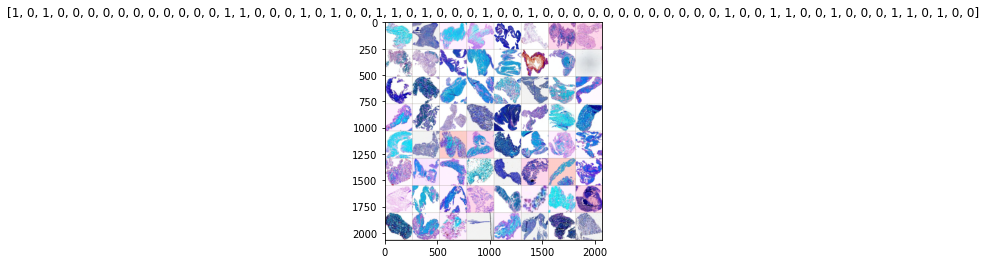

In [71]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataset_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
z=train['enc_label'].values
print(z)
imshow(out, title=[z[x] for x in classes])

In [69]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataset_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                z=train['enc_label'].values
                ax.set_title(f'predicted: {z[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


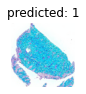

IndexError: index 793 is out of bounds for axis 0 with size 600

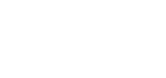

In [70]:
visualize_model(model_ft)